# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#ignore harmless warning
import warnings
warnings.filterwarnings('ignore')

### 1b. Load the data
Call the variable `cigData`. 

In [113]:
cigData = pd.read_csv("CowboyCigsData.csv", usecols=['Time', '#CigSales'], parse_dates=['Time'], index_col ='Time')

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [114]:
cigData.head()

,#CigSales
Time,
1949-01-01,1000112
1949-02-01,1000118
1949-03-01,1000132
1949-04-01,1000129
1949-05-01,1000121


## This data was altered to obfuscate the fact that it comes from a well-known data set that has nothing to do with cigarette sales. In fact, the altered version DOES NOT WORK with the exercises given.

In the next line, I remove the alteration by subtracting 10e5 and then alter the data by multiplying by 10e3 in order to make a new dataset where the where the scale is roughly the same but the variance is commensurate to the scale.

This alteration will make many of the exercises work (like taking the log to decrease variance)

In [115]:
cigData = (cigData - 1000000) * 100000

In [116]:
cigData.shape

(144, 1)

In [117]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   #CigSales  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [118]:
cigData.columns

Index(['#CigSales'], dtype='object')

Let's check out the data types of our columns.

In [119]:
cigData.dtypes

#CigSales    int64
dtype: object

Check whether there are any null values. 

In [120]:
cigData.isnull().sum()

#CigSales    0
dtype: int64

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [121]:
#We have aleady done this during import. 

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [122]:
cigData.rename_axis(index = {'Time':'Month'}, inplace = True)

Call a head() to check this has worked. 

In [123]:
cigData.head()

,#CigSales
Month,
1949-01-01,11200000
1949-02-01,11800000
1949-03-01,13200000
1949-04-01,12900000
1949-05-01,12100000


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [124]:
#did this during import.
cigData.head()

,#CigSales
Month,
1949-01-01,11200000
1949-02-01,11800000
1949-03-01,13200000
1949-04-01,12900000
1949-05-01,12100000


In [125]:
cigData['Month'].astype('datetime')

KeyError: 'Month'

Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [126]:
y = cigData['#CigSales']

Check the type of our new variable. 

In [127]:
y.dtype

dtype('int64')

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [128]:
y.describe()

count    1.440000e+02
mean     2.802986e+07
std      1.199663e+07
min      1.040000e+07
25%      1.800000e+07
50%      2.655000e+07
75%      3.605000e+07
max      6.220000e+07
Name: #CigSales, dtype: float64

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

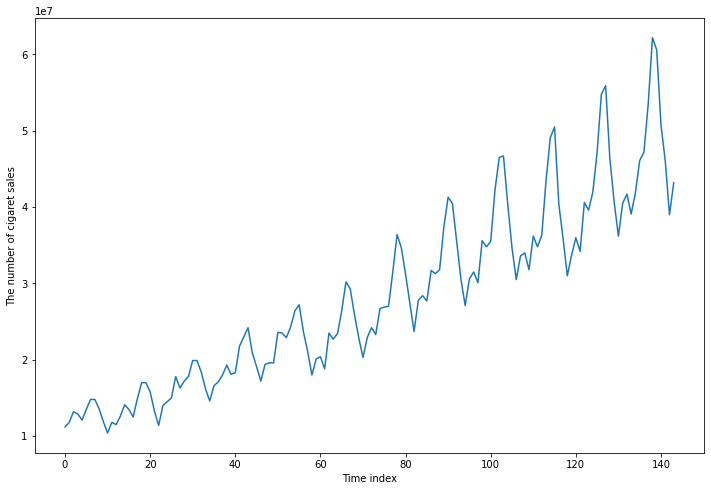

In [129]:
plt.figure(figsize=(12,8))
plt.plot(range(len(y)),y)
plt.xlabel('Time index')
plt.ylabel('The number of cigaret sales')
plt.show()

In [130]:
print(y)

Month
1949-01-01    11200000
1949-02-01    11800000
1949-03-01    13200000
1949-04-01    12900000
1949-05-01    12100000
                ...   
1960-08-01    60600000
1960-09-01    50800000
1960-10-01    46100000
1960-11-01    39000000
1960-12-01    43200000
Name: #CigSales, Length: 144, dtype: int64


## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

-------------------------------

## We use multiplicative model since the magnitude of the seasonality changes with respect to time.

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Month'>

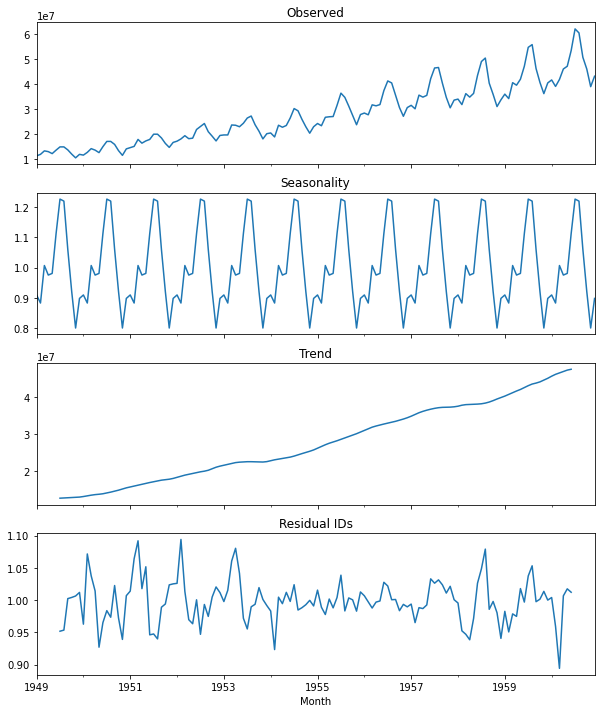

In [131]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(y, model='multiplicative')

# Plot the original data, the trend, the seasonality, and the residuals 


fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize= (10,12), sharex = True)
res.observed.plot(ax =ax1, title = 'Observed')
res.seasonal.plot(ax= ax2, title = 'Seasonality')
res.trend.plot(ax = ax3, title = 'Trend')
res.resid.plot(ax= ax4, title = 'Residual IDs')








### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [132]:
from statsmodels.tsa.stattools import kpss


statistic, p_value, n_lags, critical_values = kpss(cigData, nlags='auto')

print('Statistic: ', statistic)
print('p-value: ', p_value)
print('Number of Lags: ', n_lags)
print('Critical Values: ', critical_values)


Statistic:  1.6513122354165233
p-value:  0.01
Number of Lags:  8
Critical Values:  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

In [133]:
# Another test for stationarity is the Augmented Dickey-Fuller Test
# This function taken from Jose Portilla's Time Series class

from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}\n')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    print() #empty line for formatting
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is STATIONARY")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is NOT STATIONARY")

In [134]:
adf_test(cigData)

Augmented Dickey-Fuller Test: 

ADF test statistic        0.815369
p-value                   0.991880
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770

Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is NOT STATIONARY


### 3c. Making the data stationary 
Let's recall what it looks like. 

In [135]:
cigData.describe()

,#CigSales
count,1.440000e+02
mean,2.802986e+07
std,1.199663e+07
min,1.040000e+07
25%,1.800000e+07
50%,2.655000e+07
75%,3.605000e+07
max,6.220000e+07


In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One ofte  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

In [136]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import datetime as dt


# utility - polynomial regression
def get_polyregr_pred (df: pd.DataFrame, degree=1, retmodel=False) -> np.ndarray:
    """Return an array of Polynomial regression predictions from a DataFrame
    Alternatively, if retmodel==True, return the entire model
    
    Keyword Arguments:
    df -- A DataFrame with 'Month' and '#CigSales' columns, holding datetime objects and integer prices
    degree -- the degree of the polynomial.  (reminder that degree 1 will return straight linear regressor)
    """
    # @TODO: Assert 'Month' and '#CigSales' columns with datetime and float elements - throw TypeError
    
    # format the data into ndarrays
    df2 = df.reset_index()
    x_arr = df2.Month.map(dt.datetime.toordinal).values.reshape(-1,1)
    y_arr = df2['#CigSales'].values.reshape(-1,1)
    
    # build a polynomial regression pipeline
    polyreg = make_pipeline( PolynomialFeatures(degree),
                             LinearRegression() )
    
    # fit the model to our data
    polyreg.fit(x_arr, y_arr) 
    
    if retmodel == True:
        return polyreg
    
    return polyreg.predict(x_arr)

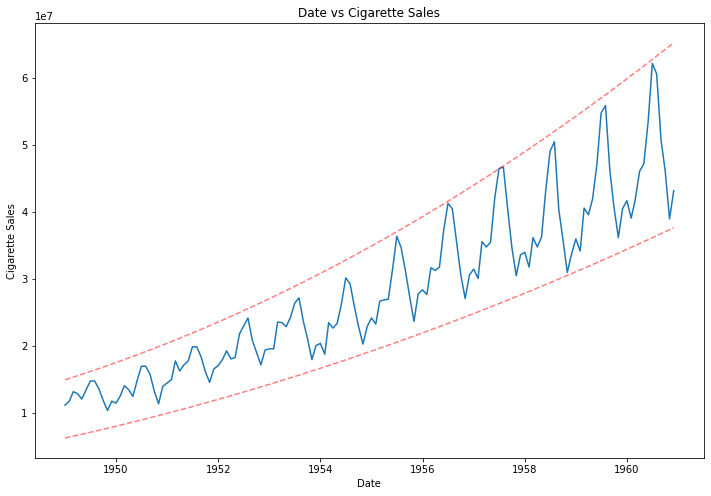

In [137]:
df_reset = cigData.reset_index()
ord_months = df_reset.Month.map(dt.datetime.toordinal).values.reshape(-1,1)

# gather the max and min sales for each year (window)
maxima = df_reset.groupby(df_reset.index//12).max()
minima = df_reset.groupby(df_reset.index//12).min()

# build a regressor model for the max/min data
predmax = get_polyregr_pred(maxima, degree=2, retmodel=True)
predmin = get_polyregr_pred(minima, degree=2, retmodel=True)

plt.figure(figsize=(12,8))

# the orig data
plt.plot(cigData)

# plot the predicted trajectories for max and min as bounding boxes 
# to help visualize the pre-differencing variance
plt.plot(cigData.index, predmax.predict(ord_months)+0.3e7, color='red', alpha=.5, ls='--')
plt.plot(cigData.index, predmin.predict(ord_months)-0.4e7, color='red', alpha=.5, ls='--')

plt.title('Date vs Cigarette Sales')
plt.xlabel('Date')
plt.ylabel('Cigarette Sales');

In our plot, we can see that both the mean and the variance increase as time progresses. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant).

One ofte used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now.

In [138]:
dflog = np.log(cigData)


When you plot this, you can see how the variance in our data now remains contant over time.

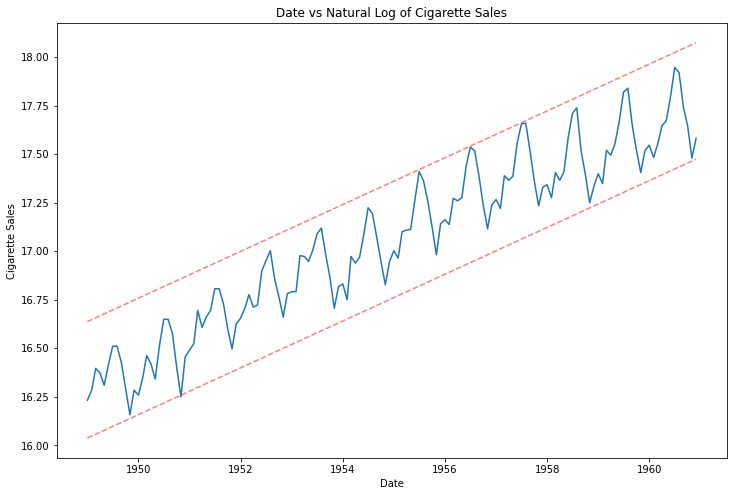

In [139]:
# get a linear regression line to visualize decreased variance in the data
# from year to year
pred = get_polyregr_pred(dflog)

plt.figure(figsize=(12,8))

plt.title('Date vs Natural Log of Cigarette Sales')
plt.plot(dflog)

# use the regression lines to bound the extremities of the data along the y axis
plt.plot(cigData.reset_index().Month, pred+.3, color='red', alpha=.5, ls='--')
plt.plot(cigData.reset_index().Month, pred-.3, color='red', alpha=.5, ls='--')

plt.xlabel('Date')
plt.ylabel('Cigarette Sales')

plt.show()

## Student Note: We can test the effect of our power transformation on the variance by taking the histogram and checking for uniformity or decreased skew

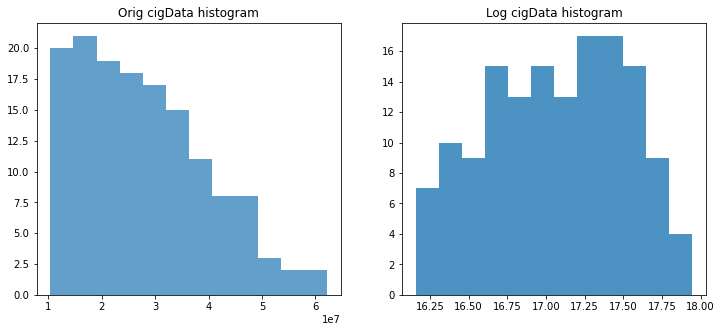

In [140]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.title('Orig cigData histogram')
plt.hist(cigData, bins=12, alpha=0.7)

plt.subplot(122)
plt.title('Log cigData histogram')
plt.hist(dflog, bins=12, alpha=0.8)

plt.show()

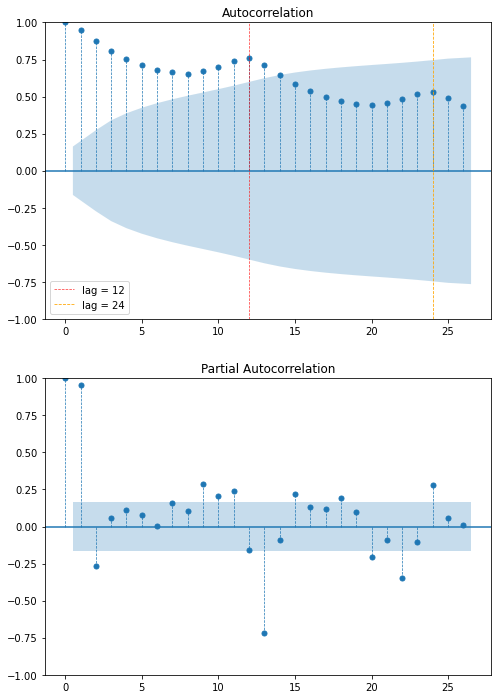

In [141]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(8,12))

# plot the ACF
plot_acf(cigData, ax=ax[0], vlines_kwargs={'ls':'--', 'linewidth': 0.7}, lags=26)

# place marker lines on lags 12 and 24 to highligh the period of seasonality
ax[0].axvline(12, color='red', ls='--', alpha=0.8, lw=0.7, label='lag = 12')
ax[0].axvline(24, color='orange', ls='--', alpha=1, lw=0.8, label='lag = 24')
ax[0].legend()

# plot the PACF
plot_pacf(cigData, ax=ax[1], vlines_kwargs={'ls':'--', 'linewidth': 0.7}, lags=26)

plt.show()

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

Student Note: When differencing with period=12, we can clearly see some economic effects. I did some research into those visible dips and we can clearly see the effect on sales of the 1953-1954 Recession caused by the sharp increase in interest rates

We also see the effect of the 1958 Recession.

There were also smaller recessions in 1949 and in 1960

Note we have to be careful about making assumptions, relating the data together. The timing of the recessions seem to be coincidental to a decline in sales.

references:

https://en.wikipedia.org/wiki/Recession_of_1953
https://en.wikipedia.org/wiki/Recession_of_1958

In [142]:
# Difference the data with period 12, corresponding to 12 months 
dfdiff = dflog.diff(12)

# remove the first 12 records as they are now filled with NaNs
dfdiff = dfdiff.iloc[12:]

ConversionError: Failed to convert value(s) to axis units: '1953-07'

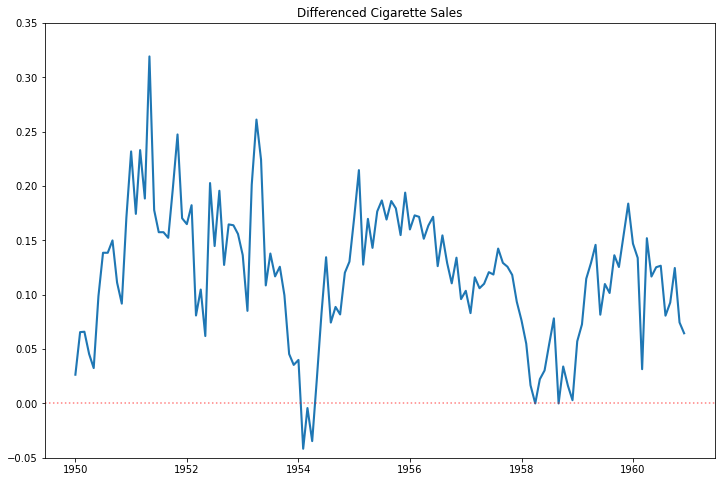

In [143]:
plt.figure(figsize=(12,8))
plt.ylim(-0.05, 0.35)

# plot the differenced data
plt.title('Differenced Cigarette Sales')
plt.plot(dfdiff, lw=2.1)

# add lines to highlight where in the data, the recessions hit.
plt.axhline(0, color='red', alpha=0.5, ls=':')
plt.axvline('1953-07', color='orange', ls='--', label='1953-1954 Recession')
plt.axvline('1958-01', color='purple', ls='--', label='1958 Recession')

# plt.axvline('1960-08', color='grey', ls=':', label='1960-1961 Recession')


plt.legend()
plt.show()

Here is the differenced data again, but with a 12 month moving average to smooth out the noise

InvalidIndexError: (slice(None, None, None), None)

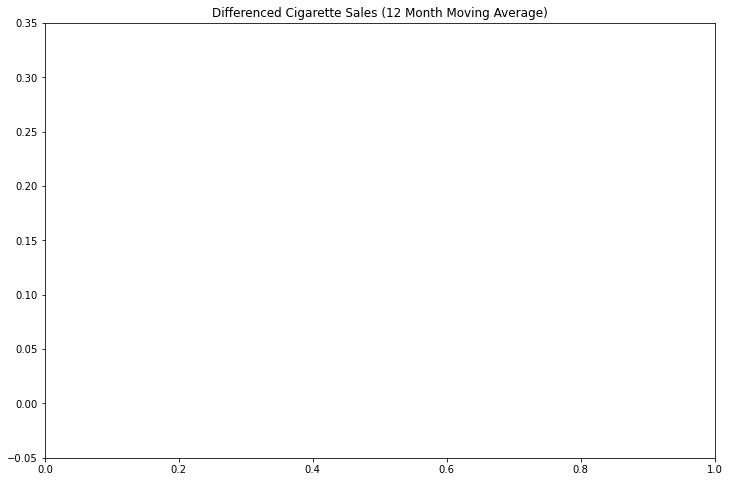

In [144]:
from datetime import timedelta

plt.figure(figsize=(12,8))
plt.ylim(-0.05, 0.35)

# We take the same plot, but use a 12 mo rolling average, shifted back
# to alignment.
plt.title('Differenced Cigarette Sales (12 Month Moving Average)')
plt.plot(dfdiff.index - timedelta(days=365/2), (dfdiff.rolling(12).mean()), 
         color='green')

# we again plot the marker lines for the recessions - it's clearer now.
plt.axhline(0, color='red', alpha=0.5, ls=':')
plt.axvline('1953-07', color='orange', ls='--', label='1953-1954 Recession')
plt.axvline('1958-01', color='purple', ls='--', label='1958 Recession')

plt.legend()
plt.show()

Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [145]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

In [146]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


from pandas.plotting import autocorrelation_plot

#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier. 

In [147]:
def get_mse(data, order=(0,0,0), seasonal_order=(0,0,0,0)):
    """
    Creates a 'Seasonal AR Integrated Moving Average w/ eXogenous factors'
    ('SARIMAX') model.
    
    Creates a Train-Test split, fits the data, forecasts the data over the 
    validation period, then compares the forecasted data with the actual data
    """
    
    # Train-Test split. Validation is 24 months in prep to forecast 24 months out
    X = data.iloc[:len(data)-24]
    y = data.drop(X.index)
      
    # define and fit the model
    model = SARIMAX(X, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    
    # predict the future!
    pred = model_fit.forecast(len(y))
    
    # return the MSE on our prediction
    return mean_squared_error(y, pred)

Student Note: As a sanity check, we use pmdarima.auto_arima to find the best model. Here we see it's a SARIMAX with using seasonality: p=2, d=0, q=0, ps=0, pd=1, pq=1, period=12

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [148]:
from pmdarima import auto_arima # for determining ARIMA orders

# from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMAResults
# from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders

# Perform a train-test-split with validation period of 24 months
# The rule of thumb when forecasting is that the validation length should
# be at least the same size as the projected forecast length
X = dflog.iloc[:len(dfdiff)-24]
y = dflog.drop(X.index)

# Perform the 'auto_arima' grid search to find the best paramaters for our model
auto_arima(X, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood                 179.891
Date:                            Wed, 05 Apr 2023   AIC                           -347.781
Time:                                    17:32:49   BIC                           -332.395
Sample:                                         0   HQIC                          -341.562
                                            - 108                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0564      0.026      2.180      0.029       0.006       0.107
ar.L1          0.5597      0.105      5.318      0.000       0.353       0.766
ar.L2          0.2077      0.099      2.091      0.037       0.013       0.402
ar.S.L12      -0.5615      0.119     -4.731      0.000      -0.794      -0.329
ar.S.L24      -0.2665      0.141     -1.889      0.059      -0.543       0.010
sigma2         0.0013      0.000      6.952      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 7.69
Prob(Q):                              0.92   Prob(JB):                         0.02
Heteroskedasticity (H):               0.28   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [149]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
# Make a function to evaluate different SARIMAX models with different p, d, and q values.
# As well as different Seasonal p, d, and q values.  It then compares the MSEs
# for all models and returns the model parameters for the lowest Error model.

def get_pdq (data):
    i = 0
    mses = pd.DataFrame()  # holds model parameters and MSEs
    
    # nested loop through all parameters.  this loop could be optimized but
    # is left as-is because it's easier to understand.
    for p in range(0,2):
        for d in range(0,2):
            for q in range (0,3):
                for ps in range(0,2):
                    for ds in range(0,2):
                        for qs in range(0,2):
                            # build/fit/predict model and get the MSE
                            mse = get_mse(data, order=(p,d,q), 
                                          seasonal_order=(ps,ds,qs,12))
                            
                            # save the parameters and MSE
                            mses = mses.append(
                                pd.DataFrame({'p':p, 
                                              'd':d, 
                                              'q':q,
                                              'ps':ps,
                                              'ds':ds,
                                              'qs':qs,
                                              'mse':mse}, index=[i]))
                            i = i+1
             
    # sort our collection by MSE and return the parameters with the lowest MSE
    mses = mses.sort_values(by='mse', axis=0, ascending=True).reset_index()
    return mses.iloc[0]

In [150]:
# Finally, we can find an optimum SARIMAX model for our data.
# Nb. this can take a while...!

# Get the optimal parameters for our model
pdq = get_pdq(dflog)

print('mse: '.ljust(6), pdq.mse)
print()
print('p:'.ljust(6), int(pdq.p))
print('d:'.ljust(6), int(pdq.d))
print('q:'.ljust(6), int(pdq.q))
print('ps:'.ljust(6), int(pdq.ps))
print('ds:'.ljust(6), int(pdq.ds))
print('qs:'.ljust(6), int(pdq.qs))
print('s:'.ljust(6), 12)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.24907D+00    |proj g|=  3.47278D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   3.473D-08   4.249D+00
  F =   4.2490746640683117     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.2

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.24055D+04    |proj g|=  9.73403D+05

At iterate    5    f=  1.16047D+01    |proj g|=  2.04716D+01

At iterate   10    f=  2.60393D+00    |proj g|=  8.14231D-01

At iterate   15    f=  1.59151D+00    |proj g|=  3.02765D-01

At iterate   20    f=  4.25805D-01    |proj g|=  2.92288D-01

At iterate   25    f=  2.04350D-02    |proj g|=  4.02435D+00

At iterate   30    f= -2.82400D-02    |proj g|=  5.39473D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f=  2.06558D-01    |proj g|=  1.87765D+00

At iterate   25    f= -5.96609D-02    |proj g|=  4.61121D-01

At iterate   30    f= -6.76148D-02    |proj g|=  1.41278D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     98      3     0     0   5.296D-04  -6.761D-02
  F =  -6.7614791316243775E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.28698D-01    |proj g|=  4.34721D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -8.29238D-01    |proj g|=  1.14906D-01

At iterate   10    f= -8.29864D-01    |proj g|=  1.48697D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     21      1     0     0   2.552D-04  -8.299D-01
  F = -0.82986544062355150     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.46811D-01    |proj g|=  9.65425D+00

At iterate    5    f= -7.51425D-01    |proj g|=  2.90898D+00

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.51932D+00    |proj g|=  1.78670D+00

At iterate    5    f=  3.64974D+00    |proj g|=  3.73905D-02

At iterate   10    f=  3.58243D+00    |proj g|=  1.56752D-03

At iterate   15    f=  3.58030D+00    |proj g|=  7.14909D-04

At iterate   20    f=  3.58005D+00    |proj g|=  1.03077D-04

At iterate   25    f=  3.58003D+00    |proj g|=  6.27796D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     25     28      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  3.05760D+00    |proj g|=  3.63582D-02

At iterate   10    f=  3.04739D+00    |proj g|=  2.79685D-03

At iterate   15    f=  3.04577D+00    |proj g|=  6.87781D-04

At iterate   20    f=  3.04531D+00    |proj g|=  2.88026D-05

At iterate   25    f=  3.04525D+00    |proj g|=  4.61474D-05

At iterate   30    f=  3.04525D+00    |proj g|=  3.76487D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     42      1     0     0   8.308D-06   3.045D+00
  F =   3.0452449207217893     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -8.77353D-01    |proj g|=  7.80363D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     23      1     0     0   7.804D-04  -8.774D-01
  F = -0.87735306277785530     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.83164D-01    |proj g|=  4.06509D+00

At iterate    5    f= -9.52147D-01    |proj g|=  6.27213D-02

At iterate   10    f= -9.53405D-01    |proj g|=  2.90508D-03

       

 This problem is unconstrained.



At iterate   30    f= -4.30432D-01    |proj g|=  4.03494D-03
  ys=-2.551E-11  -gs= 3.695E-10 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     64      1     1     0   2.276D-03  -4.304D-01
  F = -0.43043205392300882     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.31269D+00    |proj g|=  3.61090D+00

At iterate    5    f=  3.11353D+00    |proj g|=  3.60258D-01

At iterate   10  

 This problem is unconstrained.



At iterate   20    f= -3.34865D-01    |proj g|=  2.97035D+00

At iterate   25    f= -4.39817D-01    |proj g|=  1.20717D-01

At iterate   30    f= -4.40102D-01    |proj g|=  4.95152D-02
  ys=-5.639E-08  -gs= 7.574E-07 BFGS update SKIPPED

At iterate   35    f= -4.40112D-01    |proj g|=  1.09096D-02

At iterate   40    f= -4.43808D-01    |proj g|=  3.99312D-01

At iterate   45    f= -4.48221D-01    |proj g|=  5.61866D-03

At iterate   50    f= -4.48231D-01    |proj g|=  2.55806D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50    104      1     1     0   2.558D-03  -4.482D-01
  F = -0.44823088803993183     

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.07193D+00    |proj g|=  2.09199D-01

At iterate   15    f= -1.08809D+00    |proj g|=  1.36091D+00

At iterate   20    f= -1.09564D+00    |proj g|=  2.07318D-01

At iterate   25    f= -1.13908D+00    |proj g|=  7.49005D-02

At iterate   30    f= -1.16258D+00    |proj g|=  1.02058D-01

At iterate   35    f= -1.16740D+00    |proj g|=  1.50926D-01

At iterate   40    f= -1.16938D+00    |proj g|=  1.05356D-01
  ys=-6.687E-05  -gs= 3.809E-05 BFGS update SKIPPED

At iterate   45    f= -1.16948D+00    |proj g|=  1.52593D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     45     77      1     1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.24908D+00    |proj g|=  9.87047D-01

At iterate    5    f=  2.94579D+00    |proj g|=  3.64406D-02

At iterate   10    f=  2.93498D+00    |proj g|=  1.15118D-02

At iterate   15    f=  2.93396D+00    |proj g|=  6.73659D-04

At iterate   20    f=  2.93338D+00    |proj g|=  5.38076D-04

At iterate   25    f=  2.93331D+00    |proj g|=  1.94662D-04

At iterate   30    f=  2.93330D+00    |proj g|=  9.25127D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.12126D+00    |proj g|=  4.13586D-01

At iterate   10    f= -1.13984D+00    |proj g|=  1.96197D-02

At iterate   15    f= -1.14052D+00    |proj g|=  2.19519D-01

At iterate   20    f= -1.14058D+00    |proj g|=  3.87306D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     32      1     0     0   2.230D-04  -1.141D+00
  F =  -1.1405806431621917     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   20    f= -2.50641D-01    |proj g|=  1.92401D+00

At iterate   25    f= -4.02025D-01    |proj g|=  3.77855D-01

At iterate   30    f= -4.05077D-01    |proj g|=  1.00330D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     89      1     0     0   4.118D-03  -4.051D-01
  F = -0.40507740101401929     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.76510D+00    |proj g|=  2.14366D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.47344D+00    |proj g|=  4.23585D-01

At iterate   10    f=  1.13432D+00    |proj g|=  6.41111D-02

At iterate   15    f=  1.08436D+00    |proj g|=  8.30682D-03

At iterate   20    f=  1.02555D-01    |proj g|=  6.88911D-01

At iterate   25    f= -2.15534D-01    |proj g|=  3.57888D-01

At iterate   30    f= -3.29106D-01    |proj g|=  1.31139D-01

At iterate   35    f= -4.29834D-01    |proj g|=  2.53513D-01

At iterate   40    f= -4.31598D-01    |proj g|=  2.02924D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   45    f= -4.31600D-01    |proj g|=  8.26873D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48    140      2     0     0   1.467D-03  -4.316D-01
  F = -0.43159980128609338     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.20615D-01    |proj g|=  5.09323D+00

At iterate    5    f= -1.14449D+00    |proj g|=  1.55879D-01

At iterate   10    f= -1.19982D+00    |proj g|=  1.74232D+00

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.25060D+00    |proj g|=  2.98029D-01

At iterate   10    f= -1.26127D+00    |proj g|=  5.34409D-02

At iterate   15    f= -1.26462D+00    |proj g|=  1.04688D+00

At iterate   20    f= -1.27401D+00    |proj g|=  3.00589D-02

At iterate   25    f= -1.27779D+00    |proj g|=  3.03365D-01

At iterate   30    f= -1.30755D+00    |proj g|=  1.15467D+00

At iterate   35    f= -1.32241D+00    |proj g|=  3.86430D-01

At iterate   40    f= -1.32592D+00    |proj g|=  3.15370D-02

At iterate   45    f= -1.32685D+00    |proj g|=  2.42878D-01

At iterate   50    f= -1.32694D+00    |proj g|=  8.97967D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.59996D+00    |proj g|=  6.32137D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     35      1     0     0   6.321D-03  -1.600D+00
  F =  -1.5999551233603246     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.58155D+00    |proj g|=  1.01949D+00

At iterate    5    f= -1.58352D+00    |proj g|=  1.16430D+00

At iterate   10    f= -1.58575D+00    |proj g|=  1.66436D-04

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.67095D+00    |proj g|=  4.38969D+00

At iterate   30    f= -1.68770D+00    |proj g|=  6.70643D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     52      1     0     0   1.410D-03  -1.688D+00
  F =  -1.6877058213081473     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.56458D+00    |proj g|=  5.36466D-01

At iterate    5    f= -1.56475D+00    |proj g|=  1.29811D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f= -1.57388D+00    |proj g|=  7.43562D-01

At iterate   10    f= -1.58586D+00    |proj g|=  7.06572D-02

At iterate   15    f= -1.59885D+00    |proj g|=  3.16071D-01

At iterate   20    f= -1.59998D+00    |proj g|=  1.32850D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     36      1     0     0   1.595D-03  -1.600D+00
  F =  -1.5999754648850166     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.10617D+00    |proj g|=  2.07335D+00

At iterate   10    f= -1.16668D+00    |proj g|=  5.35733D-02

At iterate   15    f= -1.16754D+00    |proj g|=  8.76929D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     20      1     0     0   8.769D-05  -1.168D+00
  F =  -1.1675355225247321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.53376D+00    |proj g|=  8.40643D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.66288D+00    |proj g|=  5.10410D+00

At iterate   10    f= -1.68363D+00    |proj g|=  1.15101D-01

At iterate   15    f= -1.68634D+00    |proj g|=  1.29258D+00

At iterate   20    f= -1.68943D+00    |proj g|=  1.52176D-02

At iterate   25    f= -1.68944D+00    |proj g|=  5.79742D-02

At iterate   30    f= -1.69083D+00    |proj g|=  1.15340D+00

At iterate   35    f= -1.70988D+00    |proj g|=  2.10321D+00

At iterate   40    f= -1.72258D+00    |proj g|=  1.79281D-01

At iterate   45    f= -1.72259D+00    |proj g|=  1.57419D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     47     72   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.63767D+00    |proj g|=  1.52710D+00

At iterate   10    f= -1.64115D+00    |proj g|=  4.89764D-02

At iterate   15    f= -1.64443D+00    |proj g|=  3.96561D-01

At iterate   20    f= -1.64675D+00    |proj g|=  9.42195D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     42      1     0     0   1.062D-02  -1.647D+00
  F =  -1.6467502306453252     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.57590D-01    |proj g|=  5.58612D-01

At iterate    5    f= -8.59457D-01    |proj g|=  4.53789D-01

At iterate   10    f= -8.63099D-01    |proj g|=  5.82693D-03

At iterate   15    f= -8.63146D-01    |proj g|=  4.04564D-02

At iterate   20    f= -8.63176D-01    |proj g|=  1.69224D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     27      1     0     0   1.139D-05  -8.632D-01
  F = -0.86317555268000523     

CONVERG


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f= -1.64201D+00    |proj g|=  1.73961D+00

At iterate   10    f= -1.64408D+00    |proj g|=  2.92247D-01

At iterate   15    f= -1.64589D+00    |proj g|=  3.01295D-01

At iterate   20    f= -1.64608D+00    |proj g|=  6.17049D-02

At iterate   25    f= -1.64611D+00    |proj g|=  3.73138D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     44      1     0     0   1.836D-03  -1.646D+00
  F =  -1.6461058333051652     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10900D+00    |proj g|=  7.27198D+00

At iterate    5    f= -1.48638D+00    |proj g|=  5.84823D+00

At iterate   10    f= -1.61470D+00    |proj g|=  9.10023D-02

At iterate   15    f= -1.61604D+00    |proj g|=  1.21832D+00

At iterate   20    f= -1.62355D+00    |proj g|=  3.24686D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     50      1     0     0   3.827D-04  -1.624D+00
  F =  -1.6236716762438108     

CONVERG

 This problem is unconstrained.



At iterate   30    f= -1.72144D+00    |proj g|=  3.37314D-01

At iterate   35    f= -1.72325D+00    |proj g|=  2.11387D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     58      1     0     0   1.189D-04  -1.723D+00
  F =  -1.7232533193784008     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.60925D+00    |proj g|=  4.53122D+00

At iterate    5    f= -1.62247D+00    |proj g|=  2.43866D-01

At iter

 This problem is unconstrained.



At iterate   20    f= -1.62604D+00    |proj g|=  5.97950D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     66      2     0     0   5.980D-04  -1.626D+00
  F =  -1.6260435099045736     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.61214D+00    |proj g|=  4.51031D+00

At iterate    5    f= -1.62663D+00    |proj g|=  9.99578D-01

At iterate   10    f= -1.64108D+00    |proj g|=  1.41446D-01

At iterate   15    f= -1.64371D+00    |proj g|=  1.97388D-01

At iterate   20    f= -1.64657D+00    |proj g|=  5.94791D-02

At iterate   25    f= -1.64696D+00    |proj g|=  1.17166D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     57      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.32120D-01    |proj g|=  6.42516D-01

At iterate   20    f= -4.94002D-01    |proj g|=  1.03449D+00

At iterate   25    f= -7.45009D-01    |proj g|=  3.62193D-01

At iterate   30    f= -7.83145D-01    |proj g|=  4.25082D-02

At iterate   35    f= -7.84959D-01    |proj g|=  1.67796D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     38     50      1     0     0   8.112D-08  -7.850D-01
  F = -0.78496236540671704     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.50201D+00    |proj g|=  1.79896D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4     17      1     0     0   1.424D-03  -1.502D+00
  F =  -1.5020231851094663     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.4


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f= -6.19253D-01    |proj g|=  5.55959D+00

At iterate   20    f= -1.45216D+00    |proj g|=  3.47917D+00

At iterate   25    f= -1.49485D+00    |proj g|=  1.17857D-02

At iterate   30    f= -1.52655D+00    |proj g|=  2.00337D+00

At iterate   35    f= -1.54519D+00    |proj g|=  8.44779D-01

At iterate   40    f= -1.55063D+00    |proj g|=  1.53049D-02

At iterate   45    f= -1.55075D+00    |proj g|=  1.08284D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     46     73      1     1     0   7.249D-07  -1.551D+00
  F =  -1.5507520642551347     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   15    f= -5.18320D-01    |proj g|=  1.84100D+00

At iterate   20    f= -1.11712D+00    |proj g|=  1.67323D+00

At iterate   25    f= -1.63472D+00    |proj g|=  2.19905D-01

At iterate   30    f= -1.63753D+00    |proj g|=  2.89739D-02

At iterate   35    f= -1.65037D+00    |proj g|=  6.98454D-01

At iterate   40    f= -1.65270D+00    |proj g|=  3.17003D-03

At iterate   45    f= -1.65489D+00    |proj g|=  3.91664D-01

At iterate   50    f= -1.65652D+00    |proj g|=  1.27792D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     70      1     1     0   1.278D-01  -1.657D+00
  F =  -1.65651856835

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.45405D+00    |proj g|=  1.80119D+00

At iterate    5    f= -1.54636D+00    |proj g|=  2.37385D+00

At iterate   10    f= -1.55046D+00    |proj g|=  1.38418D-01

At iterate   15    f= -1.55359D+00    |proj g|=  2.14287D+00

At iterate   20    f= -1.59401D+00    |proj g|=  3.27089D+00


 This problem is unconstrained.



At iterate   25    f= -1.60190D+00    |proj g|=  1.72149D-02

At iterate   30    f= -1.60468D+00    |proj g|=  3.66293D-01

At iterate   35    f= -1.60871D+00    |proj g|=  2.84854D-01

At iterate   40    f= -1.60892D+00    |proj g|=  8.69181D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     42     66      1     0     0   1.308D-02  -1.609D+00
  F =  -1.6089241286632481     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.06699D+03    |proj g|=  1.74722D+05

At iterate    5    f=  6.20902D+00    |proj g|=  1.22214D+01

At iterate   10    f=  1.81428D+00    |proj g|=  5.01147D-01

At iterate   15    f= -4.22532D-01    |proj g|=  8.44368D-01

At iterate   20    f= -4.66975D-01    |proj g|=  7.24598D-01

At iterate   25    f= -6.63083D-01    |proj g|=  2.74652D-02

At iterate   30    f= -7.93535D-01    |proj g|=  1.81112D-01

At iterate   35    f= -8.09000D-01    |proj g|=  7.48186D-03

At iterate   40    f= -8.10041D-01    |proj g|=  2.49126D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.54793D+00    |proj g|=  2.97070D-01

At iterate   10    f= -1.54843D+00    |proj g|=  5.84880D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     20      1     0     0   7.080D-04  -1.548D+00
  F =  -1.5484270322840854     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.44963D+00    |proj g|=  3.45907D+00

At iterate    5    f= -1.48812D+00    |proj g|=  7.24199D+00

At iter

 This problem is unconstrained.



At iterate   10    f=  1.58049D+00    |proj g|=  4.17802D-01

At iterate   15    f= -8.54218D-01    |proj g|=  2.14403D+00

At iterate   20    f= -1.18340D+00    |proj g|=  2.47609D+00

At iterate   25    f= -1.50222D+00    |proj g|=  5.88352D-02

At iterate   30    f= -1.53511D+00    |proj g|=  9.81086D-01

At iterate   35    f= -1.53814D+00    |proj g|=  7.50802D-03

At iterate   40    f= -1.53825D+00    |proj g|=  3.91138D-01

At iterate   45    f= -1.55322D+00    |proj g|=  5.85234D+00

At iterate   50    f= -1.57662D+00    |proj g|=  9.47961D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     69   

 This problem is unconstrained.



At iterate   25    f= -1.41898D+00    |proj g|=  1.66136D+00

At iterate   30    f= -1.52876D+00    |proj g|=  2.59301D+00

At iterate   35    f= -1.61036D+00    |proj g|=  3.20420D+00

At iterate   40    f= -1.68266D+00    |proj g|=  7.61084D-01

At iterate   45    f= -1.68515D+00    |proj g|=  6.26828D-03

At iterate   50    f= -1.68516D+00    |proj g|=  7.07229D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     78      1     1     0   7.072D-03  -1.685D+00
  F =  -1.6851560421950889     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f= -1.50677D+00    |proj g|=  1.82315D+01

At iterate   10    f= -1.60256D+00    |proj g|=  5.20652D-01

At iterate   15    f= -1.63108D+00    |proj g|=  1.89147D-01

At iterate   20    f= -1.63114D+00    |proj g|=  6.32571D-02

At iterate   25    f= -1.63288D+00    |proj g|=  5.95839D-02

At iterate   30    f= -1.63608D+00    |proj g|=  5.95256D-02
  ys=-9.922E-06  -gs= 2.793E-06 BFGS update SKIPPED

At iterate   35    f= -1.63609D+00    |proj g|=  1.43975D-02
  ys=-2.002E-11  -gs= 2.095E-11 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


  ys=-1.978E-10  -gs= 2.269E-10 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38    149      3     3     0   2.580D-03  -1.636D+00
  F =  -1.6360916212125785     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.49915D+00    |proj g|=  1.19164D+00


 This problem is unconstrained.



At iterate    5    f= -1.59537D+00    |proj g|=  3.90457D-01

At iterate   10    f= -1.59637D+00    |proj g|=  9.70662D-01

At iterate   15    f= -1.60702D+00    |proj g|=  1.43188D-01

At iterate   20    f= -1.60963D+00    |proj g|=  4.09155D-01

At iterate   25    f= -1.62209D+00    |proj g|=  5.42581D+00

At iterate   30    f= -1.64611D+00    |proj g|=  1.39330D-02

At iterate   35    f= -1.64637D+00    |proj g|=  1.24897D-01

At iterate   40    f= -1.65289D+00    |proj g|=  3.27966D-01

At iterate   45    f= -1.65519D+00    |proj g|=  1.15320D-01

At iterate   50    f= -1.65528D+00    |proj g|=  2.28244D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.66183D+00    |proj g|=  5.39909D-01

At iterate   15    f= -2.44930D-01    |proj g|=  6.81564D+00

At iterate   20    f= -6.37331D-01    |proj g|=  5.95962D-01

At iterate   25    f= -8.31929D-01    |proj g|=  4.21899D-01

At iterate   30    f= -1.06824D+00    |proj g|=  1.42205D+00

At iterate   35    f= -1.10108D+00    |proj g|=  2.06440D+00

At iterate   40    f= -1.11359D+00    |proj g|=  3.61635D-02

At iterate   45    f= -1.11388D+00    |proj g|=  5.20611D-04

At iterate   50    f= -1.11388D+00    |proj g|=  2.13394D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     68   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.46553D+00    |proj g|=  4.13829D+00

At iterate   10    f= -1.62709D+00    |proj g|=  7.00094D-01

At iterate   15    f= -1.62798D+00    |proj g|=  8.78498D-01

At iterate   20    f= -1.63547D+00    |proj g|=  7.69157D-01

At iterate   25    f= -1.63708D+00    |proj g|=  4.80815D-01

At iterate   30    f= -1.63772D+00    |proj g|=  1.65435D-02

At iterate   35    f= -1.63850D+00    |proj g|=  2.12769D-01

At iterate   40    f= -1.65046D+00    |proj g|=  1.00052D+00

At iterate   45    f= -1.65448D+00    |proj g|=  6.24047D-02

At iterate   50    f= -1.65449D+00    |proj g|=  1.48776D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   45    f= -1.53555D+00    |proj g|=  2.29805D-02

At iterate   50    f= -1.55003D+00    |proj g|=  4.58803D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     71      1     0     0   4.588D-01  -1.550D+00
  F =  -1.5500327518812242     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.65931D+04    |proj g|=  5.09616D+05

At iterate    5    f=  8.88577D+00    |proj g|=  1.93444D+01

At iter

 This problem is unconstrained.



At iterate   20    f= -9.65939D-01    |proj g|=  7.19439D-01

At iterate   25    f= -1.16076D+00    |proj g|=  1.73972D+00

At iterate   30    f= -1.53356D+00    |proj g|=  8.87429D-01

At iterate   35    f= -1.65369D+00    |proj g|=  1.72452D+00

At iterate   40    f= -1.68440D+00    |proj g|=  1.06258D-02

At iterate   45    f= -1.68451D+00    |proj g|=  3.91569D-03

At iterate   50    f= -1.68455D+00    |proj g|=  5.28730D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     73      1     1     0   5.287D-02  -1.685D+00
  F =  -1.6845469426666915     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   30    f= -1.63470D+00    |proj g|=  3.12341D-01

At iterate   35    f= -1.63606D+00    |proj g|=  1.62615D-02

At iterate   40    f= -1.63613D+00    |proj g|=  1.19392D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     65      1     0     0   1.374D-02  -1.636D+00
  F =  -1.6361288711890893     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.49579D+00    |proj g|=  1.69982D+00


 This problem is unconstrained.



At iterate    5    f= -1.57978D+00    |proj g|=  7.54581D-01

At iterate   10    f= -1.58175D+00    |proj g|=  1.14471D+00

At iterate   15    f= -1.60019D+00    |proj g|=  1.20853D+00

At iterate   20    f= -1.60590D+00    |proj g|=  7.14153D-01

At iterate   25    f= -1.60878D+00    |proj g|=  3.44735D-01

At iterate   30    f= -1.61517D+00    |proj g|=  5.81434D-01

At iterate   35    f= -1.63555D+00    |proj g|=  1.68183D+00

At iterate   40    f= -1.64397D+00    |proj g|=  9.31150D-03

At iterate   45    f= -1.64616D+00    |proj g|=  1.93768D-02

At iterate   50    f= -1.65489D+00    |proj g|=  1.88581D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.10128D+00    |proj g|=  1.37259D+00

At iterate   10    f= -1.16682D+00    |proj g|=  6.22641D-02

At iterate   15    f= -1.16687D+00    |proj g|=  1.63538D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     22      1     0     0   1.656D-04  -1.167D+00
  F =  -1.1668687303861272     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.53155D+00    |proj g|=  5.73515D-02

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.02565D+00    |proj g|=  8.06095D+00

At iterate    5    f= -1.64954D+00    |proj g|=  9.95068D+00

At iterate   10    f= -1.68938D+00    |proj g|=  2.05117D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     25      1     0     0   3.470D-03  -1.689D+00
  F =  -1.6894589000094176     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     30      1     0     0   9.887D-03  -1.622D+00
  F =  -1.6223267091626958     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.61466D+00    |proj g|=  4.19344D+00

At iterate    5    f= -1.62621D+00    |proj g|=  7.06815D-01

At iterate   10    f= -1.63872D+00    |proj g|=  1.58164D-01

At iterate   15    f= -1.64085D+00    |proj g|=  5.41371D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.16789D+00    |proj g|=  1.40132D-03

At iterate   20    f= -1.16789D+00    |proj g|=  2.46243D-02

At iterate   25    f= -1.16790D+00    |proj g|=  3.41147D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     42      1     0     0   3.411D-04  -1.168D+00
  F =  -1.1679001222898486     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.53158D+00    |proj g|=  5.36151D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.53568D+00    |proj g|=  4.92681D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     38      1     0     0   4.927D-03  -1.536D+00
  F =  -1.5356839631823505     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.61602D+00    |proj g|=  4.71614D+00

At iterate    5    f= -1.63111D+00    |proj g|=  8.31211D-01

At iterate   10    f= -1.64437D+00    |proj g|=  3.52201D-01

At iter

 This problem is unconstrained.



At iterate   45    f= -1.62196D+00    |proj g|=  2.29599D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     47     63      1     0     0   2.210D-04  -1.622D+00
  F =  -1.6219644620269273     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.01895D+00    |proj g|=  7.98055D+00

At iterate    5    f= -1.67206D+00    |proj g|=  1.31347D+00

At iterate   10    f= -1.67618D+00    |proj g|=  2.75534D-01

At iter

 This problem is unconstrained.



At iterate   20    f= -1.68964D+00    |proj g|=  2.26827D-02

At iterate   25    f= -1.69003D+00    |proj g|=  4.02707D-01

At iterate   30    f= -1.69155D+00    |proj g|=  1.18457D-02

At iterate   35    f= -1.69167D+00    |proj g|=  1.15427D-01

At iterate   40    f= -1.71390D+00    |proj g|=  5.57300D+00

At iterate   45    f= -1.72739D+00    |proj g|=  5.99399D-01

At iterate   50    f= -1.72899D+00    |proj g|=  1.12382D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     70      1     0     0   1.124D-02  -1.729D+00
  F =  -1.7289904264003664     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.61271D+00    |proj g|=  4.53282D+00

At iterate    5    f= -1.62809D+00    |proj g|=  1.19437D+00

At iterate   10    f= -1.63885D+00    |proj g|=  5.52744D-02

At iterate   15    f= -1.64127D+00    |proj g|=  2.76295D-01


 This problem is unconstrained.



At iterate   20    f= -1.64528D+00    |proj g|=  1.13763D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     46      1     0     0   1.954D-02  -1.645D+00
  F =  -1.6452895210039633     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.68370D-01    |proj g|=  5.14172D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -8.83745D-01    |proj g|=  1.42955D+00

At iterate   10    f= -8.90130D-01    |proj g|=  5.96285D-02

At iterate   15    f= -8.91810D-01    |proj g|=  4.98723D-01

At iterate   20    f= -8.94247D-01    |proj g|=  2.91352D-01

At iterate   25    f= -8.95256D-01    |proj g|=  3.17056D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     31      1     0     0   4.139D-06  -8.953D-01
  F = -0.89525551480848498     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.53408D+00    |proj g|=  5.22266D-01

At iterate    5    f= -1.53493D+00    |proj g|=  1.14408D-01

At iterate   10    f= -1.53506D+00    |proj g|=  3.05394D-02

At iterate   15    f= -1.53507D+00    |proj g|=  4.64129D-02

At iterate   20    f= -1.53520D+00    |proj g|=  2.39850D-01

At iterate   25    f= -1.53762D+00    |proj g|=  6.46180D-02

At iterate   30    f= -1.53789D+00    |proj g|=  4.31505D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f= -1.63343D+00    |proj g|=  8.99468D-01

At iterate   10    f= -1.64512D+00    |proj g|=  6.09796D-02

At iterate   15    f= -1.64563D+00    |proj g|=  5.36164D-01

At iterate   20    f= -1.64613D+00    |proj g|=  5.34472D-02

At iterate   25    f= -1.64614D+00    |proj g|=  7.39723D-02

At iterate   30    f= -1.64624D+00    |proj g|=  1.55608D-03

At iterate   35    f= -1.64625D+00    |proj g|=  4.22317D-02

At iterate   40    f= -1.64660D+00    |proj g|=  8.99242D-02

At iterate   45    f= -1.64718D+00    |proj g|=  6.62272D-02

At iterate   50    f= -1.64720D+00    |proj g|=  5.75392D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   40    f= -1.63734D+00    |proj g|=  1.84422D-01

At iterate   45    f= -1.63787D+00    |proj g|=  1.14610D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     72      1     0     0   8.350D-04  -1.638D+00
  F =  -1.6378804154070827     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.02468D+00    |proj g|=  7.96944D+00

At iterate    5    f= -1.67871D+00    |proj g|=  1.92321D+00


 This problem is unconstrained.



At iterate   10    f= -1.68086D+00    |proj g|=  2.31431D-01

At iterate   15    f= -1.69100D+00    |proj g|=  2.72010D-02

At iterate   20    f= -1.69246D+00    |proj g|=  3.20479D-01

At iterate   25    f= -1.69284D+00    |proj g|=  1.64143D-02

At iterate   30    f= -1.69311D+00    |proj g|=  3.98293D-01

At iterate   35    f= -1.69861D+00    |proj g|=  3.55294D-01

At iterate   40    f= -1.70386D+00    |proj g|=  8.70269D-03

At iterate   45    f= -1.70598D+00    |proj g|=  2.96901D-01

At iterate   50    f= -1.70732D+00    |proj g|=  3.47780D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     76   

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     31      1     0     0   2.572D-03  -1.626D+00
  F =  -1.6264439973834754     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.61523D+00    |proj g|=  4.53380D+00

At iterate    5    f= -1.63030D+00    |proj g|=  1.10198D+00

At iterate   10    f= -1.64148D+00    |proj g|=  2.96493D-02


 This problem is unconstrained.



At iterate   15    f= -1.64371D+00    |proj g|=  1.98870D-01

At iterate   20    f= -1.64619D+00    |proj g|=  3.07557D-02

At iterate   25    f= -1.64711D+00    |proj g|=  7.26502D-02

At iterate   30    f= -1.64712D+00    |proj g|=  1.81870D-02

At iterate   35    f= -1.64713D+00    |proj g|=  4.32571D-02

At iterate   40    f= -1.64723D+00    |proj g|=  4.69373D-02

At iterate   45    f= -1.64765D+00    |proj g|=  2.81192D-01

At iterate   50    f= -1.64787D+00    |proj g|=  4.39816D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     69      1     0     0   4.398D-02  -1.648D+00
  F =  -1.64786971117

In [151]:
# define and fit the model
model = SARIMAX(dflog, order=(pdq.p, pdq.d, pdq.q), 
                seasonal_order=(pdq.ps, pdq.ds, pdq.qs, 12), freq='MS')
model_fit = model.fit()

# predict the future!
forecast = model_fit.forecast(24)
pred = model_fit.predict()[12:]  # give it 1 period to create predictions

model_fit.mse

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.15014D+00    |proj g|=  7.86446D+00

At iterate    5    f= -1.75731D+00    |proj g|=  9.42726D-01


 This problem is unconstrained.



At iterate   10    f= -1.75801D+00    |proj g|=  4.30419D-01

At iterate   15    f= -1.76263D+00    |proj g|=  1.96010D-01

At iterate   20    f= -1.76269D+00    |proj g|=  1.19522D-01

At iterate   25    f= -1.76683D+00    |proj g|=  5.18876D-01

At iterate   30    f= -1.77286D+00    |proj g|=  3.56928D-01

At iterate   35    f= -1.77321D+00    |proj g|=  8.37202D-02

At iterate   40    f= -1.77539D+00    |proj g|=  1.65816D-01

At iterate   45    f= -1.77545D+00    |proj g|=  8.16231D-03

At iterate   50    f= -1.77545D+00    |proj g|=  8.39906D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     67   

1.83156397924903

In [152]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            #CigSales   No. Observations:                  144
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood                 255.664
Date:                              Wed, 05 Apr 2023   AIC                           -499.329
Time:                                      17:33:54   BIC                           -481.552
Sample:                                  01-01-1949   HQIC                          -492.105
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8486      0.122      6.944      0.000       0.609       1.088
ma.L1         -1.2014      0.147     -8.170      0.000      -1.490      -0.913
ma.L2          0.2396      0.111      2.151      0.031       0.021       0.458
ar.S.L12       0.9906      0.008    131.763      0.000       0.976       1.005
ma.S.L12      -0.5660      0.108     -5.240      0.000      -0.778      -0.354
sigma2         0.0013      0.000      8.478      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 5.39
Prob(Q):                              0.93   Prob(JB):                         0.07
Heteroskedasticity (H):               0.64   Skew:                             0.04
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Now, we choose a couple of values to try for each parameter.
_ _ _

In [ ]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
_ _ _

So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

In [ ]:
_ _ _

We can take a look at a summary of the model this library has built around our data.

In [ ]:
_ _ _

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

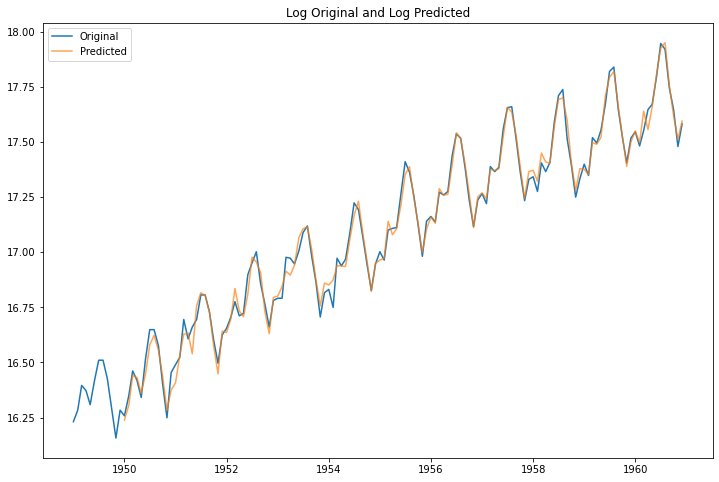

In [153]:
# Overlay our prediction over the actual data to get a sense of how good 
# the model is.

plt.figure(figsize=(12,8))

plt.title('Log Original and Log Predicted')
plt.plot(dflog, label='Original')
plt.plot(pred, alpha=0.7, label='Predicted')

plt.legend()
plt.show()
# plt.plot(forecast)

In [154]:
# define and fit the model
model = SARIMAX(dflog, order=(2,0,0), seasonal_order=(0, 1, 1, 12), freq='MS')
model_fit_aa = model.fit()

# predict the future!
forecast_aa = model_fit_aa.forecast(24)
pred_aa = model_fit_aa.predict()[12:] # # give it 1 period to create predictions

model_fit_aa.mse


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.54314D+00    |proj g|=  1.79534D+00

At iterate    5    f= -1.67850D+00    |proj g|=  1.49008D+00

At iterate   10    f= -1.68069D+00    |proj g|=  2.20959D-01

At iterate   15    f= -1.68292D+00    |proj g|=  1.27825D+00

At iterate   20    f= -1.68384D+00    |proj g|=  2.87454D-02

At iterate   25    f= -1.68996D+00    |proj g|=  1.06183D+00

At iterate   30    f= -1.69908D+00    |proj g|=  7.61432D-02

At iterate   35    f= -1.69937D+00    |proj g|=  4.56698D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

22.276640205913953

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

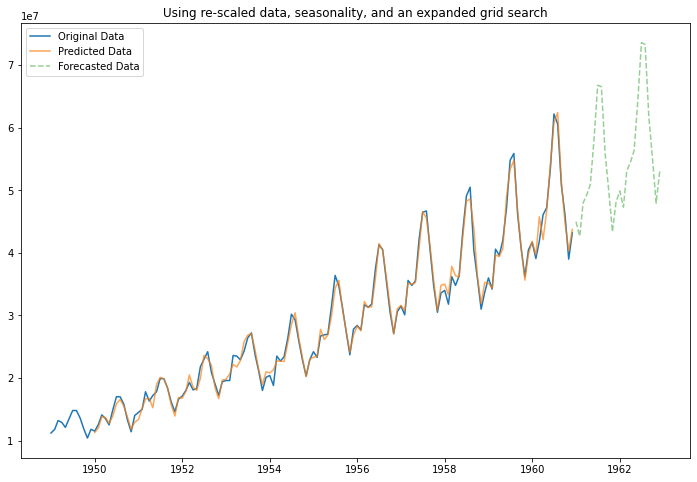

In [155]:
plt.figure(figsize=(12,8))

# plot our original data, with prediction overlay and then project the forecast
plt.title('Using re-scaled data, seasonality, and an expanded grid search')
plt.plot(np.exp(dflog), label='Original Data')
plt.plot(np.exp(pred), alpha=0.7, label='Predicted Data')
plt.plot(np.exp(forecast), label='Forecasted Data', alpha=0.5, ls='--')

plt.legend()
plt.show()

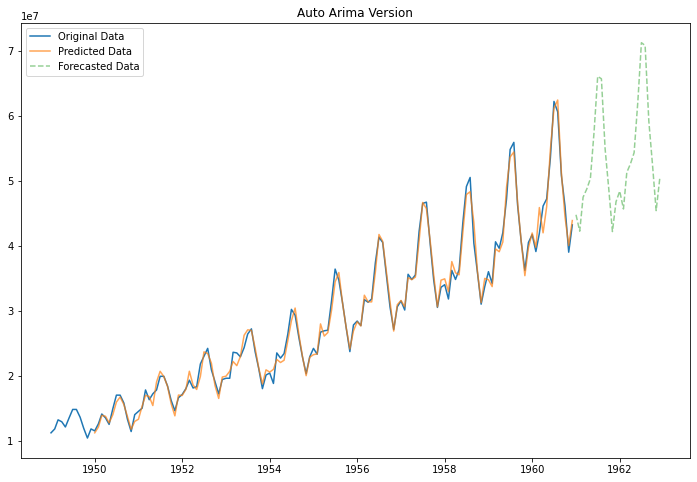

In [156]:
plt.figure(figsize=(12,8))

# plot our original data, with prediction overlay and then project the forecast
plt.title('Auto Arima Version')
plt.plot(np.exp(dflog), label='Original Data')
plt.plot(np.exp(pred_aa), alpha=0.7, label='Predicted Data')
plt.plot(np.exp(forecast_aa), label='Forecasted Data', alpha=0.5, ls='--')

plt.legend()
plt.show()

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 